In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Use scikit-learn's built-in *make_classification* method to generate syntehtic classificiation data

In [6]:
from sklearn.datasets import make_classification

#### I used two informative features (Temp, Humidity) and one redundant feature 'Crime'

In [7]:
X,y = make_classification(n_samples=35040,n_classes=2,n_features=3,n_informative=2,n_redundant=1,
                           weights=[0.999,0.001],class_sep=1.0)

In [8]:
df=pd.DataFrame(data=X,columns=['Temp','Humidity','Crime'])

In [9]:
df['y']=y

In [10]:
df['Temp']=df['Temp']-min(df['Temp'])
maxt=max(df['Temp'])
df['Temp']=90*df['Temp']/maxt

In [11]:
df['Humidity']=df['Humidity']-min(df['Humidity'])
maxh=max(df['Humidity'])
df['Humidity']=100*df['Humidity']/maxh

In [12]:
df['Crime']=df['Crime']-min(df['Crime'])
maxc=max(df['Crime'])
df['Crime']=10*df['Crime']/maxc

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A1F3DE1358>]], dtype=object)

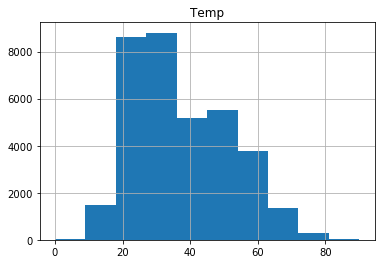

In [13]:
df.hist('Temp')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A1F5ECCE10>]], dtype=object)

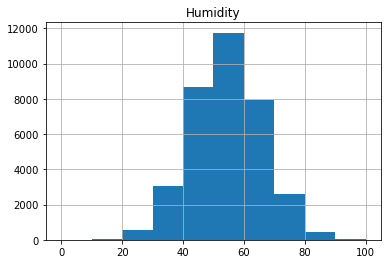

In [14]:
df.hist('Humidity')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A1F63B6320>]], dtype=object)

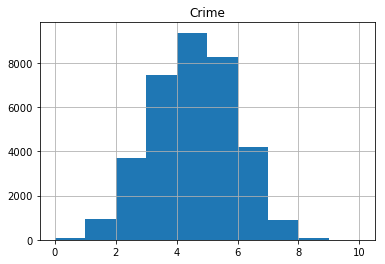

In [15]:
df.hist('Crime')

### Take a sum on the Boolean array with df['y']==1 to count the number of positive examples

In [16]:
sum(df['y']==1)

208

** That means only 223 responses out of 35040 samples are positive **

In [17]:
df.head(10)

,Temp,Humidity,Crime,y
0,69.911963,46.390916,2.534920,0
1,20.128522,51.172110,6.095530,0
2,19.693976,40.932844,6.777327,0
3,30.870842,55.299898,5.000659,0
4,58.606409,43.638177,3.586468,0
5,26.217064,65.517227,4.715108,0
6,56.447058,48.694281,3.434018,0
7,26.279376,65.724995,4.697123,0
8,21.143146,51.311586,6.007967,0
9,18.781879,42.698414,6.736358,0


In [18]:
df.describe()

,Temp,Humidity,Crime,y
count,35040.000000,35040.000000,35040.000000,35040.000000
mean,37.361268,54.390121,4.554580,0.005936
std,14.222773,11.484604,1.344826,0.076818
min,0.000000,0.000000,0.000000,0.000000
25%,25.933047,46.659770,3.594520,0.000000
50%,34.015027,54.381585,4.577618,0.000000
75%,48.535355,62.111284,5.530735,0.000000
max,90.000000,100.000000,10.000000,1.000000


## Logistic Regression undersampling

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report

### Under-sampling the negative class to limited number

In [20]:
df0=df[df['y']==0].sample(800)
df1=df[df['y']==1]
df_balanced = pd.concat([df0,df1],axis=0)
df_balanced.describe()

,Temp,Humidity,Crime,y
count,1008.000000,1008.000000,1008.000000,1008.000000
mean,36.854106,55.607657,4.516875,0.206349
std,14.022719,12.461692,1.347383,0.404885
min,9.234639,6.753112,0.881205,0.000000
25%,25.630422,46.964145,3.507509,0.000000
50%,33.154437,55.707893,4.528937,0.000000
75%,48.634513,63.714781,5.506327,0.000000
max,78.978767,100.000000,8.812841,1.000000


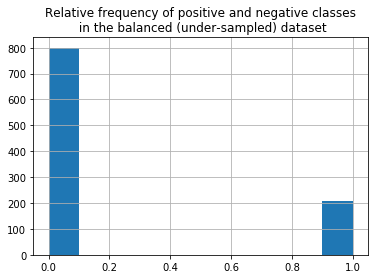

In [21]:
df_balanced.hist('y')
plt.title("Relative frequency of positive and negative classes\n in the balanced (under-sampled) dataset")

In [22]:
log_model_balanced = LogisticRegressionCV(cv=5,class_weight='balanced')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop('y',axis=1), 
                                                    df_balanced['y'], test_size=0.30)

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler=MinMaxScaler()

In [26]:
X_train = scaler.fit_transform(X_train)

In [27]:
log_model_balanced.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [28]:
print(classification_report(y_test,log_model_balanced.predict(X_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       233
          1       0.23      1.00      0.38        70

avg / total       0.05      0.23      0.09       303



C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### I did an experiment with how the degree of under-sampling affects _F1-score_, _precision_, and _recall_

In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [30]:
n_neg = [i for i in range(200,4200,200)]

df1=df[df['y']==1]
F1_scores=[]
precision_scores=[]
recall_scores=[]

for num in n_neg:
    # Create under-sampled data sets
    df0=df[df['y']==0].sample(num)
    df_balanced = pd.concat([df0,df1],axis=0)
    # Create model with 'class_weight=balanced' and 5-fold cross-validation
    log_models=LogisticRegressionCV(cv=5,class_weight='balanced')
    # Create test/train splits
    X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop('y',axis=1), 
                                                    df_balanced['y'], test_size=0.30)
    # Min-max scale the training data
    X_train = scaler.fit_transform(X_train)
    
    # Fit the logistic regression model
    log_models.fit(X_train,y_train)
    
    # Calculate various scores
    F1_scores.append(f1_score(y_test,log_models.predict(X_test)))
    precision_scores.append(precision_score(y_test,log_models.predict(X_test)))
    recall_scores.append(recall_score(y_test,log_models.predict(X_test)))

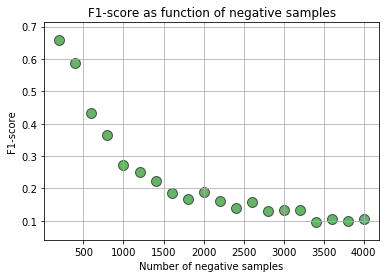

In [31]:
plt.scatter(n_neg,F1_scores,color='green',edgecolor='black',alpha=0.6,s=100)
plt.title("F1-score as function of negative samples")
plt.grid(True)
plt.ylabel("F1-score")
plt.xlabel("Number of negative samples")

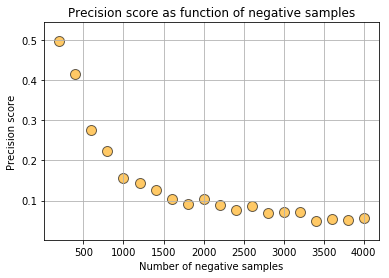

In [32]:
plt.scatter(n_neg,precision_scores,color='orange',edgecolor='black',alpha=0.6,s=100)
plt.title("Precision score as function of negative samples")
plt.grid(True)
plt.ylabel("Precision score")
plt.xlabel("Number of negative samples")

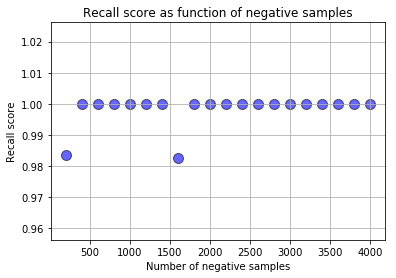

In [33]:
plt.scatter(n_neg,recall_scores,color='blue',edgecolor='black',alpha=0.6,s=100)
plt.title("Recall score as function of negative samples")
plt.grid(True)
plt.ylabel("Recall score")
plt.xlabel("Number of negative samples")

### So, precision goes down rapidly with more negative samples and so does F1-score. Recall is largely unaffected by mixing negative samples with the positive ones.